In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter
import cloudpickle

from data.dataset import dataset_qtt
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec_trig_solve, llt_inv_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot, CorrectionNet

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.graph_utils import direc_graph_from_linear_system_sparse
from train import train

plt.rcParams['figure.figsize'] = (11, 7)

# Train/retrain/overwrite

In [3]:
save_path = '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/trained_models/'
model_name = 'check27.11_no_rhs_div_k_grad_64_0.5_ilu0_llt_loss_1000epoch'
train_from_scratch = True

# Setup experiment

In [4]:
pde = 'div_k_grad'      # 'poisson', 'div_k_grad'
grid = 64            # 32, 64, 128
variance = .5        # 0.1, 0.5, 1.0 1.5
lhs_type = 'l_ilu0'      # 'fd', 'ilu0', 'ilu1', 'ilu2', 'ict', 'l_ict', 'a_pow'
N_train = 1000
N_test = 200
precision = 'f64'

fill_factor = 1     # int
threshold = 1e-4     # float
power = 2            # int
N_valid_CG = 300     # Number of CG iterations for validation in the very end

In [5]:
with_cond = False
layer_ = Conv1d
# layer_ = ConstantConv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
alpha = jnp.array([0.])

loss_type = 'llt'               # 'llt', 'llt-res', 'inv-prec'

2024-11-27 09:59:49.478711: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
batch_size = 8
epoch_num = 1000
lr = 1e-3
schedule_params = None #[1700, 2001, 300, 1e-1]    # [start, stop, step, decay_size]

In [7]:
# if (loss_type in {'notay', 'llt-res', 'llt-res-norm'} and dataset == 'simple') or (loss_type in {'llt', 'llt-norm'} and dataset == 'krylov'):
#     raise ValueError('Not valid dataset for a chosen loss')

if schedule_params != None:
    assert len(schedule_params) == 4
    
    start, stop, step, decay_size = schedule_params
    steps_per_batch = N_train // batch_size
    start, stop, step = start*steps_per_batch, stop*steps_per_batch, step*steps_per_batch
    lr = optax.piecewise_constant_schedule(
        lr,
        {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
    )

In [8]:
model_config = {
    'node_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_dec': {
        'features': [16, 16, 1],
        'N_layers': 2,
        'layer_': layer_
    },
    'mp': {
        'edge_upd': {
            'features': [48, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'node_upd': {
            'features': [32, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'mp_rounds': 5
    }
}

# Make dataset

In [9]:
s1 = perf_counter()
A_train, A_pad_train, b_train, u_exact_train, bi_edges_train = dataset_qtt(pde, grid, variance, lhs_type,
                                                                           return_train=True, N_samples=N_train,
                                                                           fill_factor=fill_factor, threshold=threshold,
                                                                           power=power, precision=precision)
A_test, A_pad_test, b_test, u_exact_test, bi_edges_test = dataset_qtt(pde, grid, variance, lhs_type,
                                                                      return_train=False, N_samples=N_test,
                                                                      fill_factor=fill_factor, threshold=threshold,
                                                                      power=power, precision=precision)
print(perf_counter() - s1)

34.75688558071852


# Train model

In [10]:
seed = 42
NodeEncoder = FullyConnectedNet(**model_config['node_enc'], key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(**model_config['edge_enc'], key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(**model_config['edge_dec'], key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(**model_config['mp']['edge_upd'], key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(**model_config['mp']['node_upd'], key=random.PRNGKey(seed)),
    mp_rounds=model_config['mp']['mp_rounds']
)

# model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
#                 EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)

model = CorrectionNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass, alpha=alpha)

# w = jnp.zeros(A_pad_train[0, ...].nse)
# b = alpha
# model = ShiftNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
#                 EdgeDecoder=EdgeDecoder, MessagePass=MessagePass, w=w, b=b)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2754


In [11]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_train, A_pad_train, b_train, bi_edges_train, u_exact_train],
    [A_test, A_pad_test, b_test, bi_edges_test, u_exact_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size,
}

In [ ]:
if train_from_scratch:
    s = perf_counter()
    model, losses = train(model, data, train_config, loss_name=loss_type, repeat_step=1, with_cond=with_cond)
    dt = perf_counter() - s
    
    with open(save_path + model_name + '.pkl', 'wb') as f:
        cloudpickle.dump(model, f)
else:
    with open(save_path + model_name + '.pkl', 'rb') as f:
        model = cloudpickle.load(f)
    losses, dt = [np.nan], np.nan

In [14]:
dt

1607.2038992010057

In [15]:
print('alpha:', end='')
model.alpha

alpha:

Array([-0.08115357], dtype=float32)

Final values
  train loss: 414.8598
   test loss: 420.8809
    LLT cond: 1

Minimim test loss `403.8612` at epoch `952`

Minimim test P^(-1)A cond `1` at epoch `0`


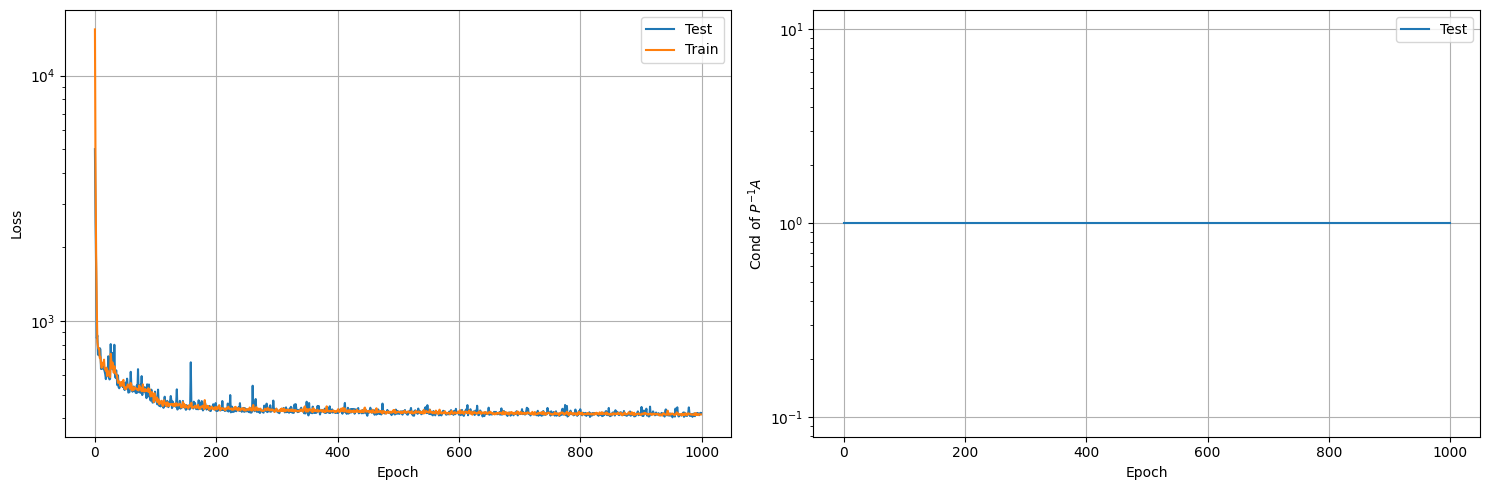

In [27]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cond of $P^{-1}A$')
axes[1].grid();

plt.tight_layout()

print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')

In [28]:
losses[1][500], losses[1][-1]

(Array(421.81662, dtype=float32), Array(420.88086, dtype=float32))

## Forward call time

In [55]:
def calc_forward(model, A_i, b_i, bi_edges_i, num_rounds=200):
    nodes_i, edges_i, receivers_i, senders_i, _ = direc_graph_from_linear_system_sparse(A_i[None, ...], b_i[None, ...])
    jit_model = jit(lambda t1, t2, t3, t4, t5: model((t1, t2, t3, t4), t5))
    L = jit_model(nodes_i[0, ...], edges_i[0, ...], receivers_i[0, ...], senders_i[0, ...], bi_edges_i)
    
    t_ls = []
    for _ in range(num_rounds):
        s = perf_counter()
        L = jit_model(nodes_i[0, ...], edges_i[0, ...], receivers_i[0, ...], senders_i[0, ...], bi_edges_i)
        t_ls.append(perf_counter() - s)
    return np.mean(t_ls), np.std(t_ls)

def calc_forward_PrecNet(model, A_i, A_lhs_i, b_i, bi_edges_i, num_rounds=200):
    nodes_i, edges_i, receivers_i, senders_i, _ = direc_graph_from_linear_system_sparse(A_i[None, ...], b_i[None, ...])
    lhs_nodes_i, lhs_edges_i, lhs_receivers_i, lhs_senders_i, _ = direc_graph_from_linear_system_sparse(A_lhs_i[None, ...], b_i[None, ...])
    
    jit_model = jit(lambda t1, t2, t3, t4, t5, t6, t7, t8, t9: model((t1, t2, t3, t4), t5, (t6, t7, t8, t9)))
    L = jit_model(nodes_i[0, ...], edges_i[0, ...], receivers_i[0, ...], senders_i[0, ...], bi_edges_i,
                  lhs_nodes_i[0, ...], lhs_edges_i[0, ...], lhs_receivers_i[0, ...], lhs_senders_i[0, ...])
    
    t_ls = []
    for _ in range(num_rounds):
        s = perf_counter()
        L = jit_model(nodes_i[0, ...], edges_i[0, ...], receivers_i[0, ...], senders_i[0, ...], bi_edges_i,
                      lhs_nodes_i[0, ...], lhs_edges_i[0, ...], lhs_receivers_i[0, ...], lhs_senders_i[0, ...])
        t_ls.append(perf_counter() - s)
    return np.mean(t_ls), np.std(t_ls)

In [56]:
i = 0
# mean_, std_ = calc_forward(model, A_pad_test[i, ...], b_test[i, ...], bi_edges_test[i, ...], num_rounds=200)
mean_, std_ = calc_forward_PrecNet(model, A_pad_test[i, ...], A_test[i, ...], b_test[i, ...], bi_edges_test[i, ...], num_rounds=200)

TypeError: CorrectionNet.__call__() takes 2 positional arguments but 4 were given

In [ ]:
print(f'Grid = {grid}, lhs_type = {lhs_type}. Average over 200 forward calls {mean_:.6f}±{std_:.6f}')

## Make precs

In [21]:
nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad_test, jnp.ones_like(b_test))
# lhs_nodes, lhs_edges, lhs_receivers, lhs_senders, _ = direc_graph_from_linear_system_sparse(A_test, b_test)

L = vmap(model, in_axes=(0), out_axes=(0))((nodes, edges, receivers, senders), bi_edges_test)#, (lhs_nodes, lhs_edges, lhs_receivers, lhs_senders))
# del model, data, A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, bi_edges_test
# clear_caches()

# Apply model to CG

In [22]:
from linsolve.scipy_linsolve import batched_cg_scipy, make_Chol_prec_from_bcoo, cg_scipy
from utils import jBCOO_to_scipyCSR

import scipy.sparse.linalg as sci_sp_linalg
import scipy.linalg as sci_linalg

In [23]:
P = make_Chol_prec_from_bcoo(L)

In [24]:
_, iters_mean, iters_std, time_mean, time_std = batched_cg_scipy(A_test, b_test, P=P, atol=1e-12, maxiter=300)

In [26]:
# No rhs in input
print('iters')
display(iters_mean)
iters_std

iters


[38.0, 49.455, 60.185, 70.465]

[1.2649110640673518, 1.314524628905826, 1.3714135043815194, 1.55524113885918]

In [23]:
# No biedge averaging
print('iters')
display(iters_mean)
iters_std

iters


[38.435, 50.02, 60.715, 71.07]

[1.1600754285821246, 1.2488394612599332, 1.312926121303099, 1.495025083401613]

In [25]:
# From submit
print('iters')
display(iters_mean)
iters_std

iters


[38.45, 49.92, 60.69, 71.155]

[1.255985668708047, 1.2975361266646874, 1.4573606279847138, 1.5687495019919528]

### Classical prec

In [69]:
from linsolve.scipy_linsolve import make_Chol_prec

In [ ]:
P_class = make_Chol_prec(L)

In [ ]:
_, iters_mean, iters_std, time_mean, time_std = batched_cg_scipy(A_test, b_test, P=P_class, atol=1e-12, maxiter=400)

In [ ]:
print('iters')
display(iters_mean)
iters_std

# Spectrum w/ PreCorrecrtor

In [67]:
cond, lambda_min, lambda_max = [], [], []
loss, lambda_max_bound = [], []
lambda_min_bound, lambda_min_long_bound = [], []
i = 


# for i in range(1, A_test.shape[0]):
print(i)
A_i = jBCOO_to_scipyCSR(A_test[i, ...]).todense(order='C')
L_i = jBCOO_to_scipyCSR(L[i, ...])
P_i = (L_i @ L_i.T).todense(order='C')
print(' A, L and P are combined')

Pinv_i = sci_linalg.inv(P_i)
Ainv_i = sci_linalg.inv(A_i)
print(' A and P are inverted')

Pinv_A_i = Pinv_i @ A_i

eigen_i = np.abs(sci_linalg.eigvals(Pinv_A_i))
eigen_min_i = np.min(eigen_i)
eigen_max_i = np.max(eigen_i)
cond_i = eigen_max_i / eigen_min_i
print(' Eigenvalues are calculated')


P_Ainv_i = P_i @ Ainv_i
sqrt_loss = np.linalg.norm(P_Ainv_i - np.eye(P_i.shape[0]), ord='fro')
loss_i = np.square(sqrt_loss)
min_bound_i = 1 / (np.linalg.norm(P_Ainv_i, ord='fro'))
min_bound_long_i = 1 / (sqrt_loss + 1)
max_bound_i = np.linalg.norm(A_i - P_i, ord=2) * np.linalg.norm(Pinv_i, ord=2) + 1
print(' Norms are calculated')

cond.append(cond_i)
lambda_min.append(eigen_min_i)
lambda_max.append(eigen_max_i)
loss.append(loss_i)
lambda_max_bound.append(max_bound_i)
lambda_min_bound.append(min_bound_i)
lambda_min_long_bound.append(min_bound_long_i)
print(' All done')
print(f'  cond = {cond[-1]:.5f}, lambda_min = {lambda_min[-1]:.5f}, lambda_max = {lambda_max[-1]:.5f}')
print(f'  loss = {loss[-1]:.5f}, lambda_max_bound = {lambda_max_bound[-1]:.5f}')
print(f'  lambda_min_bound = {lambda_min_bound[-1]:.5f}, lambda_min_long_bound = {lambda_min_long_bound[-1]:.5f}')

SyntaxError: invalid syntax (1041602960.py, line 4)

In [68]:
cond.append(cond_i)
lambda_min.append(eigen_min_i)
lambda_max.append(eigen_max_i)
loss.append(loss_i)
lambda_max_bound.append(max_bound_i)
lambda_min_bound.append(min_bound_i)
lambda_min_long_bound.append(min_bound_long_i)
print(' All done')
print(f'  cond = {cond[-1]:.5f}, lambda_min = {lambda_min[-1]:.5f}, lambda_max = {lambda_max[-1]:.5f}')
print(f'  loss = {loss[-1]:.5f}, lambda_max_bound = {lambda_max_bound[-1]:.5f}')
print(f'  lambda_min_bound = {lambda_min_bound[-1]:.5f}, lambda_min_long_bound = {lambda_min_long_bound[-1]:.5f}')

NameError: name 'cond' is not defined

# Spectrum with NLA IC(0)

In [18]:
import ilupp

In [19]:
i = 0

In [20]:
L = ilupp.ichol0(jBCOO_to_scipyCSR(A_test[i, ...]))

In [ ]:
A_i = jBCOO_to_scipyCSR(A_test[i, ...]).todense(order='C')
L_i = L
P_i = (L_i @ L_i.T).todense(order='C')
print(' A, L and P are combined')

Pinv_i = sci_linalg.inv(P_i)
Ainv_i = sci_linalg.inv(A_i)
print(' A and P are inverted')

Pinv_A_i = Pinv_i @ A_i

eigen_i = np.abs(sci_linalg.eigvals(Pinv_A_i))
eigen_min_i = np.min(eigen_i)
eigen_max_i = np.max(eigen_i)
cond_i = eigen_max_i / eigen_min_i
print(' Eigenvalues are calculated')


P_Ainv_i = P_i @ Ainv_i
sqrt_loss = np.linalg.norm(P_Ainv_i - np.eye(P_i.shape[0]), ord='fro')
loss_i = np.square(sqrt_loss)
min_bound_i = 1 / (np.linalg.norm(P_Ainv_i, ord='fro'))
min_bound_long_i = 1 / (sqrt_loss + 1)
max_bound_i = np.linalg.norm(A_i - P_i, ord=2) * np.linalg.norm(Pinv_i, ord=2) + 1
print(' Norms are calculated')

cond.append(cond_i)
lambda_min.append(eigen_min_i)
lambda_max.append(eigen_max_i)
loss.append(loss_i)
lambda_max_bound.append(max_bound_i)
lambda_min_bound.append(min_bound_i)
lambda_min_long_bound.append(min_bound_long_i)
print(' All done')
print(f'  cond = {cond[-1]:.5f}, lambda_min = {lambda_min[-1]:.5f}, lambda_max = {lambda_max[-1]:.5f}')
print(f'  loss = {loss[-1]:.5f}, lambda_max_bound = {lambda_max_bound[-1]:.5f}')
print(f'  lambda_min_bound = {lambda_min_bound[-1]:.5f}, lambda_min_long_bound = {lambda_min_long_bound[-1]:.5f}')

 A, L and P are combined
 A and P are inverted
 Eigenvalues are calculated


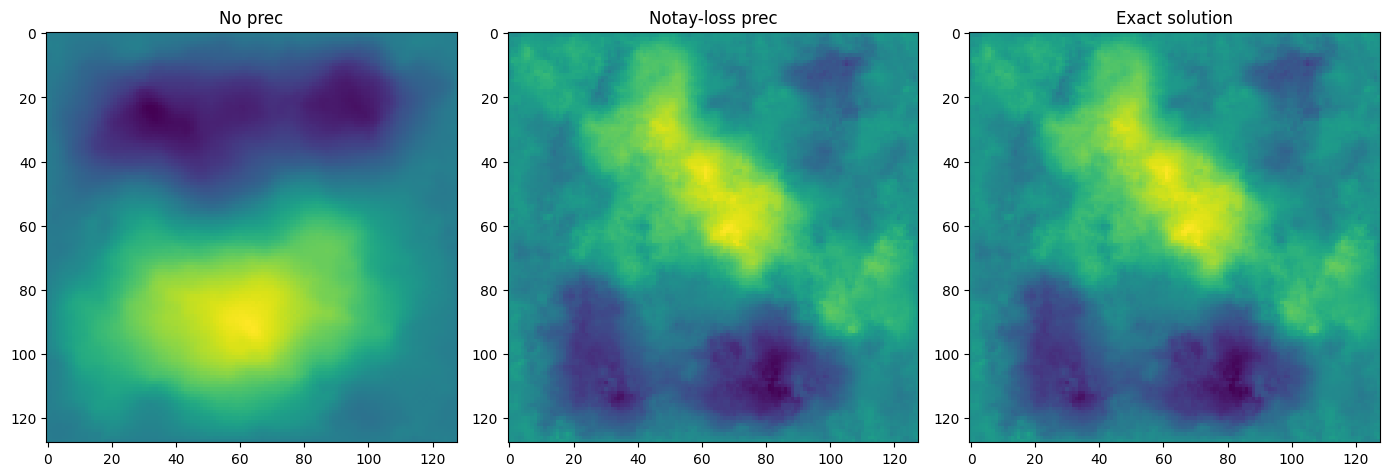

In [22]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()